In [1]:
# ============================================================================
# IMPORT CÁC THƯ VIỆN CẦN THIẾT CHO XAI-RL FRAMEWORK
# ============================================================================

# 1. System & Path
import sys
import os
sys.path.append('d:\\NCKH\\SARSA_FinancialRL')

# 2. Data Processing
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 3. Deep Learning - PyTorch
import torch
from torch import nn
import torch.nn.functional as F

# 4. Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style cho plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 5. XAI Libraries - CHỈ DÙNG SHAP
try:
    import shap
    print("✓ SHAP available")
except ImportError:
    print("⚠ SHAP not installed - will install when needed")

# 6. Project-specific Imports
from agents.d_sarsa.d_sarsa import Qsa
from environments.stock_trading_env.mdp import StockTradingMDP
from data.data_provider.library_extracted.vnstock.VNStockDataProvider import VNStockDataProvider
from data.data_processor.feature_engineer import engineer_stat as es

# 7. Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("="*80)
print("✓ Tất cả thư viện đã được import thành công!")
print("="*80)
print("\n🎯 XAI-RL Framework - 3 Phương pháp độc lập:")
print("  [1] RDX  - Reward Decomposition (weights từ domain knowledge)")
print("  [2] MSX  - Multi-Step Explanation (trajectory analysis)")
print("  [3] SHAP - Feature Attribution (Shapley values)")
print("\n📊 Deep RL Agent:")
print("  • Qsa:              Q-network (input=7, output=11)")
print("  • StockTradingMDP:  Environment cho stock trading")
print("  • VNStockData:      Data provider cho VN market")
print("\nReady to analyze SARSA agent! 🚀")
print("="*80)

✓ SHAP available


✓ Tất cả thư viện đã được import thành công!

🎯 XAI-RL Framework - 3 Phương pháp độc lập:
  [1] RDX  - Reward Decomposition (weights từ domain knowledge)
  [2] MSX  - Multi-Step Explanation (trajectory analysis)
  [3] SHAP - Feature Attribution (Shapley values)

📊 Deep RL Agent:
  • Qsa:              Q-network (input=7, output=11)
  • StockTradingMDP:  Environment cho stock trading
  • VNStockData:      Data provider cho VN market

Ready to analyze SARSA agent! 🚀


In [15]:
# 1.1. Load model SARSA
qsa = Qsa(input_size=7, num_classes=11)
model_path = 'd:\\NCKH\\SARSA_FinancialRL\\models\\sarsa_bad_fpt.pth'

if os.path.exists(model_path):
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    qsa.load_state_dict(state_dict)
    qsa.eval()
    print(f"✓ Model loaded: {model_path}")
else:
    print(f"✗ Model not found: {model_path}")

# # 1.2. Load dữ liệu ACB
# provider = VNStockDataProvider()
# print("\nĐang lấy dữ liệu ACB từ vnstock...")
# df_raw = provider.get_ohlcv_data('ACB', '2012-12-14', '2022-12-31')
# print(f"✓ Đã lấy {len(df_raw)} dòng dữ liệu")

# # 1.3. Xử lý dữ liệu và thêm technical indicators
# df_processed = df_raw.copy()
# df_processed.rename(columns={'date': 'time'}, inplace=True)
# df_processed['time'] = pd.to_datetime(df_processed['time']).dt.strftime('%d/%m/%Y')
# df_processed = es.add_technical_indicators(df_processed, start_date= '01/01/2013')
# print(f"✓ Đã thêm technical indicators: {df_processed.shape}")

df_processed = pd.read_csv('D:\\NCKH\\SARSA_FinancialRL\\data\\data_storer\\data_research\\test\\good_test_FPT.csv')

# 1.4. Khởi tạo MDP và chạy simulation
mdp = StockTradingMDP(balance_init=1000, k=5, min_balance=-100)

def pi_deep(s, eps=0.0, greedy=True):
    with torch.no_grad():
        out_qsa = qsa(torch.Tensor(s).float()).squeeze()
        action = out_qsa.argmax().item() - 5
    return action

# State ban đầu
first_row = df_processed.iloc[0]
state_init = [
    float(first_row['close']),
    mdp.balance_init,
    0,
    float(first_row['MACD']),
    float(first_row['RSI']),
    float(first_row['CCI']),
    float(first_row['ADX'])
]

# Chạy simulation
print("\nĐang chạy simulation...")
states, rewards, actions = mdp.simulate(
    df_processed[1:].reset_index(drop=True), 
    state_init, 
    pi_deep, 
    greedy=True, 
    eps=0.0
)

print(f"✓ Simulation hoàn tất: {len(states)} states, {len(actions)} actions")
print(f"  Total reward: {sum(rewards):.2f}")
print(f"  Final portfolio: ${states[-1][1] + states[-1][0]*states[-1][2]:.2f}")

✗ Model not found: d:\NCKH\SARSA_FinancialRL\models\sarsa_bad_fpt.pth

Đang chạy simulation...
✓ Simulation hoàn tất: 752 states, 751 actions
  Total reward: 2417.37
  Final portfolio: $3417.37


In [4]:
states

[[2.42,
  1000,
  0,
  0.05597283984458956,
  73.05199662703768,
  120.77641984184024,
  44.04049606668072],
 [2.38,
  987.8879,
  5.0,
  0.05996978011094045,
  66.88454158740373,
  133.79737045630318,
  45.77392166666997],
 [2.41,
  975.976,
  10.0,
  0.06481103211322736,
  68.99852787373489,
  118.38790931989921,
  47.38353115237427],
 [2.41,
  963.91395,
  15.0,
  0.06786544855817311,
  68.99852787373489,
  139.0044691015566,
  49.106139751815626],
 [2.42,
  951.8519,
  20.0,
  0.07028283524799495,
  69.74517290896681,
  130.96996553422,
  50.38232945355221],
 [2.53,
  939.7398,
  25.0,
  0.08015078396226549,
  76.46097276037852,
  177.41305197342618,
  52.089563517838585],
 [2.56,
  927.07715,
  30.0,
  0.08936184595820684,
  77.90167950757893,
  183.05773136060336,
  53.71762128206435],
 [2.55,
  914.26435,
  35.0,
  0.09476240055949159,
  76.22689574654929,
  190.79641350210966,
  55.5890669674949],
 [2.52,
  901.5016,
  40.0,
  0.09552052851708526,
  71.27624093678044,
  124.293

In [5]:
actions

[5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 2,
 2,
 2,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 3,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 4,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 3,
 -5,
 3,
 -5,
 -5,
 -5,
 0,
 -2,
 3,
 3,
 -5,
 3,
 3,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -2,
 -2,
 -2,
 0,
 0,
 -2,
 -2,
 -2,
 -2,
 3,
 -3,
 0,
 0,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 -5,
 -5,
 -5,
 3,
 3,
 3,
 -5,
 3,
 -5,
 0,
 0,
 0,
 0,
 0,
 0,
 -5,
 -5,
 3,
 -5,
 3,
 0,
 3,
 0,
 -2,
 0,
 0,
 0,
 0,
 3,
 -5,
 0,
 0,
 3,
 -5,
 -5,
 -5,
 3,
 3,
 4,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 4,
 -5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -2,
 0,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 0,
 0,
 0,
 0,
 0,
 0,
 -5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -5,
 0,
 0,
 0,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 -2,
 3,
 0,
 0,
 0,
 0,
 -2,
 0,
 3

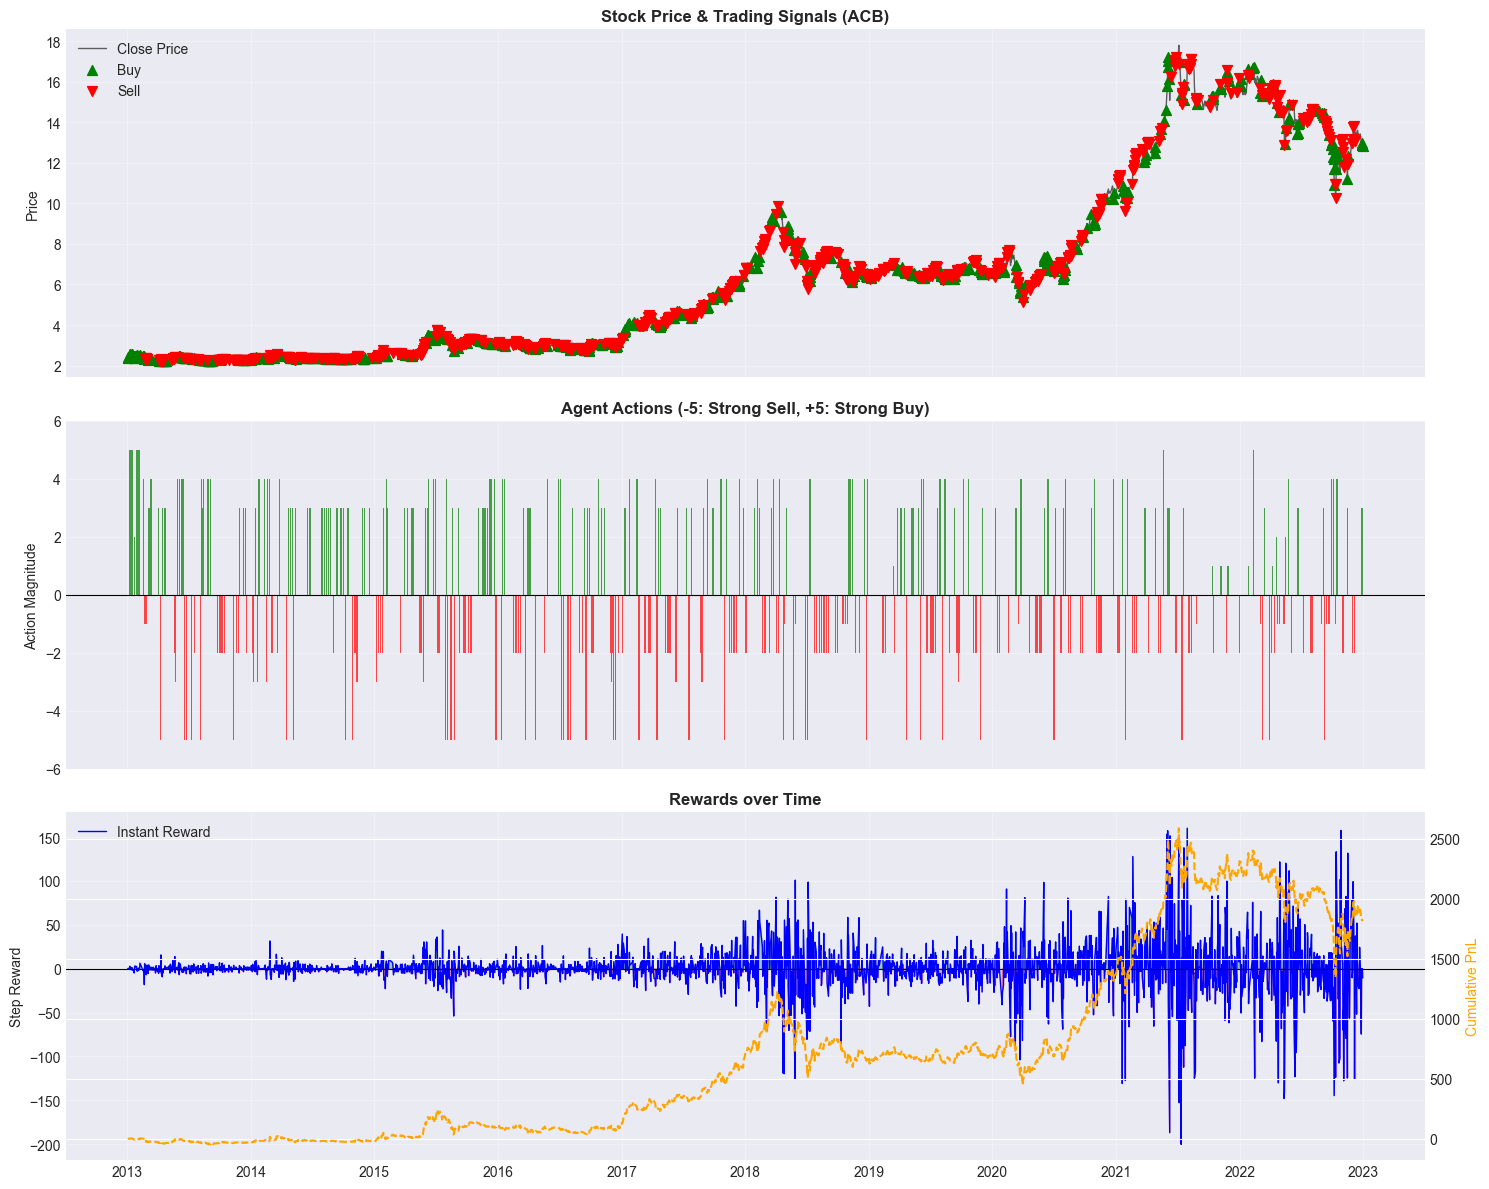

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---------------------------------------------------------
# 1. CHUẨN BỊ DỮ LIỆU ĐỂ VẼ
# ---------------------------------------------------------
# Lấy phần dữ liệu tương ứng với quá trình simulation (bỏ dòng đầu như lúc simulate)
plot_df = df_processed[1:].reset_index(drop=True).copy()

# Thêm Action và Reward vào DataFrame
plot_df['action'] = actions
plot_df['reward'] = rewards

# Chuyển đổi cột time sang datetime để hiển thị trục X cho đẹp
plot_df['date'] = pd.to_datetime(plot_df['time'], format='%d/%m/%Y')
plot_df.set_index('date', inplace=True)

# ---------------------------------------------------------
# 2. VẼ BIỂU ĐỒ (3 Subplots: Giá, Action, Reward)
# ---------------------------------------------------------
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# --- Subplot 1: Giá cổ phiếu & Điểm Mua/Bán (Để đối chiếu) ---
axes[0].plot(plot_df.index, plot_df['close'], label='Close Price', color='black', alpha=0.6, linewidth=1)

# Lấy các điểm Mua (Action > 0) và Bán (Action < 0)
buys = plot_df[plot_df['action'] > 0]
sells = plot_df[plot_df['action'] < 0]

# Vẽ mũi tên/chấm Mua Bán
axes[0].scatter(buys.index, buys['close'], marker='^', color='green', label='Buy', s=50, zorder=5)
axes[0].scatter(sells.index, sells['close'], marker='v', color='red', label='Sell', s=50, zorder=5)

axes[0].set_title(f'Stock Price & Trading Signals (ACB)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# --- Subplot 2: Actions (Hành động của Agent) ---
# Dùng Bar chart để thấy rõ cường độ (-5 đến 5)
colors = np.where(plot_df['action'] >= 0, 'green', 'red')
axes[1].bar(plot_df.index, plot_df['action'], color=colors, alpha=0.7, width=1.0)
axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].set_ylim(-6, 6)
axes[1].set_title('Agent Actions (-5: Strong Sell, +5: Strong Buy)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Action Magnitude')
axes[1].grid(True, alpha=0.3)

# --- Subplot 3: Rewards (Phần thưởng nhận được) ---
# Dùng Line chart + Fill area
axes[2].plot(plot_df.index, plot_df['reward'], color='blue', linewidth=1, label='Instant Reward')
axes[2].fill_between(plot_df.index, 0, plot_df['reward'], where=(plot_df['reward'] >= 0), color='green', alpha=0.3)
axes[2].fill_between(plot_df.index, 0, plot_df['reward'], where=(plot_df['reward'] < 0), color='red', alpha=0.3)

# Vẽ thêm đường Cumulative Reward (Lợi nhuận tích lũy) để dễ đánh giá
cum_reward = plot_df['reward'].cumsum()
ax2_twin = axes[2].twinx()
ax2_twin.plot(plot_df.index, cum_reward, color='orange', linestyle='--', linewidth=1.5, label='Cumulative Reward')
ax2_twin.set_ylabel('Cumulative PnL', color='orange')

axes[2].set_title('Rewards over Time', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Step Reward')
axes[2].legend(loc='upper left')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(0, color='black', linewidth=0.8)

# --- Layout ---
plt.tight_layout()
plt.show()

In [7]:
def calculate_reward_components(states, actions, prices):
    """
    Tính 4 thành phần reward ở ĐƠN VỊ THÔ (tiền tệ) theo đúng quy ước RL:
    r_t sinh ra khi đi từ (s_t, a_t) -> s_{t+1}.

    Yêu cầu sửa: đúng thứ tự trừ theo công thức, bỏ hoàn toàn phần CHIA (tính %).

    Đầu vào:
      - states: list/array các trạng thái (s_0..s_T), mỗi state: [price, balance, shares, ...]
      - actions: list/array hành động (a_0..a_{T-1})
      - prices:  list/np.array giá đóng cửa (P_0..P_T)

    Đầu ra:
      - R_profit, R_risk, R_position, R_stability: mỗi mảng độ dài T (đơn vị tiền)
    """
    # Số bước hợp lệ (tránh lệch chiều dài)
    n = min(len(states) - 1, len(actions), len(prices) - 1)

    # 1) Khởi tạo
    R_profit = np.zeros(n)
    R_risk = np.zeros(n)
    R_position = np.zeros(n)
    R_stability = np.zeros(n)

    # 2) Chỉ số phụ trợ
    MA10 = np.convolve(np.asarray(prices), np.ones(10) / 10, mode='same')  # cho R_position (không chia %)
    running_max_price = -np.inf  # cho R_risk: max(P_0..P_t)

    # 3) Vòng lặp cho từng bước t
    for t in range(n):
        P_t = float(prices[t])
        P_next = float(prices[t + 1])

        # Cập nhật đỉnh giá lịch sử (running max) dùng đúng thứ tự
        if P_t > running_max_price:
            running_max_price = P_t

        # Hành động tại t -> quy về dấu: 1 (mua), -1 (bán), 0 (giữ)
        a_t = actions[t]
        try:
            a_t_val = float(a_t)
        except Exception:
            a_t_val = a_t
        action_sign = 1 if a_t_val > 0 else (-1 if a_t_val < 0 else 0)

        # Trích xuất số cổ phiếu đang nắm giữ tại t
        h_t = float(states[t][2])

        # ---------------------------------------------------------------
        # 1) R_profit (ĐƠN VỊ THÔ): (P_{t+1} - P_t) * h_t
        #    (BỎ chia theo %; dùng đúng thứ tự P_{t+1} - P_t)
        # ---------------------------------------------------------------
        R_profit[t] = (P_next - P_t) * h_t

        # ---------------------------------------------------------------
        # 2) R_risk (ĐƠN VỊ THÔ): -| (running_max_price - P_t) | * |h_t|
        #    (BỎ chia theo %; chú ý THỨ TỰ TRỪ là peak - current)
        # ---------------------------------------------------------------
        drawdown_raw = running_max_price - P_t  # đúng thứ tự: đỉnh - hiện tại
        R_risk[t] = -abs(drawdown_raw) * abs(h_t)

        # ---------------------------------------------------------------
        # 3) R_position (ĐƠN VỊ THÔ): so sánh sign(P_t - MA10_t) với sign(a_t)
        #    Nếu cùng dấu: + (P_t * |h_t|); ngược dấu: - (P_t * |h_t|); nếu a_t=0 -> 0
        #    (BỎ chia %, chỉ dùng mức giá làm thang đo theo vị thế)
        # ---------------------------------------------------------------
        trend_val = P_t - MA10[t]
        sign_trend = 1 if trend_val > 0 else (-1 if trend_val < 0 else 0)
        scale_pos = P_t * abs(h_t)
        if action_sign == 0 or scale_pos == 0:
            R_position[t] = 0.0
        elif sign_trend == action_sign:
            R_position[t] = +scale_pos
        else:
            R_position[t] = -scale_pos

        # ---------------------------------------------------------------
        # 4) R_stability (ĐƠN VỊ THÔ): -| P_{t+1} - P_t | * |h_t|
        #    (BỎ chia %, dùng đúng thứ tự chênh lệch giá trong bước t)
        # ---------------------------------------------------------------
        R_stability[t] = -abs(P_next - P_t) * abs(h_t)

    return R_profit, R_risk, R_position, R_stability

# Tính toán 4 components theo (s_t, a_t) -> r_t (đơn vị thô)
prices = df_processed['close'].values
R_profit, R_risk, R_position, R_stability = calculate_reward_components(states, actions, prices)

# Chuyển rewards từ môi trường (nếu có)
R_original = np.array(rewards)

print("✓ Đã tính toán 4 reward components (ĐƠN VỊ THÔ, không chia %):")
print(f"  R_profit: mean={R_profit.mean():.4f}, std={R_profit.std():.4f}")
print(f"  R_risk: mean={R_risk.mean():.4f}, std={R_risk.std():.4f}")
print(f"  R_position: mean={R_position.mean():.4f}, std={R_position.std():.4f}")
print(f"  R_stability: mean={R_stability.mean():.4f}, std={R_stability.std():.4f}")
print(f"  R_original: mean={R_original.mean():.4f}, std={R_original.std():.4f}")

✓ Đã tính toán 4 reward components (ĐƠN VỊ THÔ, không chia %):
  R_profit: mean=0.7318, std=27.0333
  R_risk: mean=-240.9998, std=251.3115
  R_position: mean=-62.3926, std=877.3157
  R_stability: mean=-14.7270, std=22.6815
  R_original: mean=0.7278, std=27.0797


In [8]:
R_risk

array([-0.000e+00, -2.000e-01, -1.000e-01, ..., -7.986e+02, -8.232e+02,
       -8.379e+02])

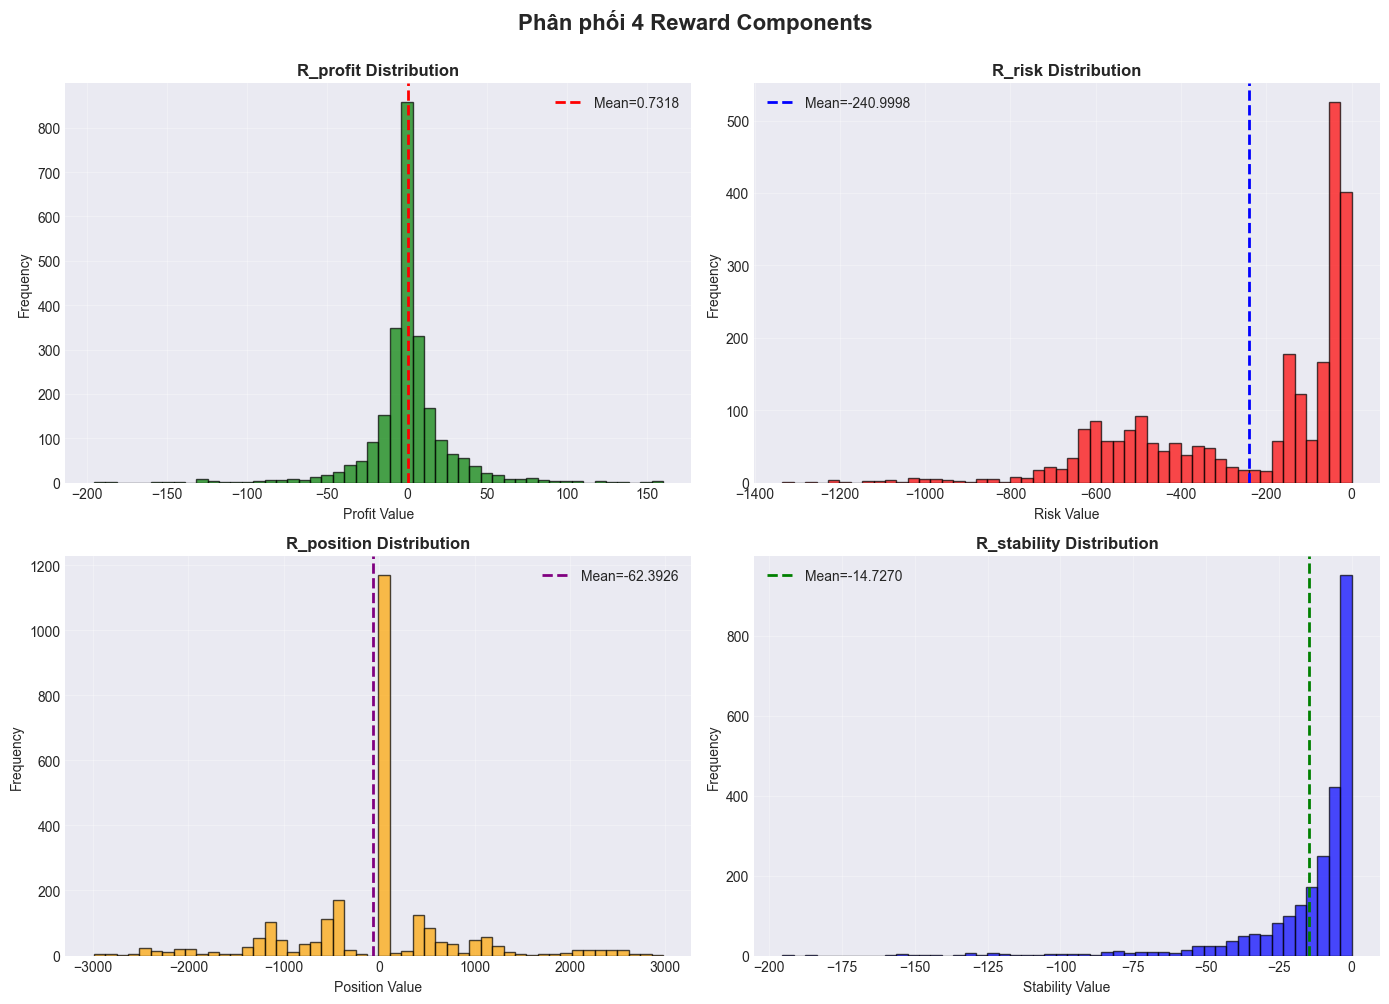

In [9]:
# Histogram phân phối của 4 components
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0,0].hist(R_profit, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0,0].set_title('R_profit Distribution', fontweight='bold')
axes[0,0].set_xlabel('Profit Value')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(R_profit.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean={R_profit.mean():.4f}')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

axes[0,1].hist(R_risk, bins=50, alpha=0.7, color='red', edgecolor='black')
axes[0,1].set_title('R_risk Distribution', fontweight='bold')
axes[0,1].set_xlabel('Risk Value')
axes[0,1].set_ylabel('Frequency')
axes[0,1].axvline(R_risk.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean={R_risk.mean():.4f}')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

axes[1,0].hist(R_position, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1,0].set_title('R_position Distribution', fontweight='bold')
axes[1,0].set_xlabel('Position Value')
axes[1,0].set_ylabel('Frequency')
axes[1,0].axvline(R_position.mean(), color='purple', linestyle='--', linewidth=2, label=f'Mean={R_position.mean():.4f}')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

axes[1,1].hist(R_stability, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[1,1].set_title('R_stability Distribution', fontweight='bold')
axes[1,1].set_xlabel('Stability Value')
axes[1,1].set_ylabel('Frequency')
axes[1,1].axvline(R_stability.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean={R_stability.mean():.4f}')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.suptitle('Phân phối 4 Reward Components', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [10]:
# ============================================================================
# PHẦN 1: RDX - ĐỊNH NGHĨA WEIGHTS TỪ DOMAIN KNOWLEDGE
# ============================================================================

# Weights được định nghĩa TRƯỚC dựa trên domain knowledge trading
# KHÔNG dùng gradient hay machine learning để tính weights!

print("="*80)
print("PHẦN 1: RDX - REWARD DECOMPOSITION EXPLANATION")
print("="*80)

# Domain knowledge weights cho trading strategy
w_rdx = np.array([
    0.8,  
    0.005,  
    0.005,  
    0.19   
])

print("\n✓ RDX Weights (Domain Knowledge):")
print(f"  w1 (R_profit):    {w_rdx[0]:.2f} - Profit maximization")
print(f"  w2 (R_risk):      {w_rdx[1]:.5f} - Risk management")
print(f"  w3 (R_position):  {w_rdx[2]:.5f} - Position sizing")
print(f"  w4 (R_stability): {w_rdx[3]:.5f} - Portfolio stability")
print(f"  Tổng: {w_rdx.sum():.2f}")

PHẦN 1: RDX - REWARD DECOMPOSITION EXPLANATION

✓ RDX Weights (Domain Knowledge):
  w1 (R_profit):    0.80 - Profit maximization
  w2 (R_risk):      0.00500 - Risk management
  w3 (R_position):  0.00500 - Position sizing
  w4 (R_stability): 0.19000 - Portfolio stability
  Tổng: 1.00


In [11]:
# Tái tạo reward từ 4 components với RDX weights
R_components = np.column_stack([R_profit, R_risk, R_position, R_stability])
R_reconstructed = R_components @ w_rdx

# Tính metrics để validate RDX
mse = mean_squared_error(R_original, R_reconstructed)
rmse = np.sqrt(mse)
mae = mean_absolute_error(R_original, R_reconstructed)
r2 = r2_score(R_original, R_reconstructed)
correlation = np.corrcoef(R_original, R_reconstructed)[0, 1]

print("✓ RDX Reconstruction Metrics:")
print(f"  MSE:         {mse:.6f}")
print(f"  RMSE:        {rmse:.6f}")
print(f"  MAE:         {mae:.6f}")
print(f"  R² Score:    {r2:.4f} {'✓ Good' if r2 > 0.7 else '✗ Poor'}")
print(f"  Correlation: {correlation:.4f} {'✓ Strong' if abs(correlation) > 0.8 else '~ Moderate' if abs(correlation) > 0.5 else '✗ Weak'}")

# # Phân tích reward theo action type
# print("\n✓ Reward Analysis by Action Type:")
# for action_type, condition in [('BUY', np.array(actions) > 0), 
#                                 ('SELL', np.array(actions) < 0), 
#                                 ('HOLD', np.array(actions) == 0)]:
#     if np.any(condition):
#         avg_original = R_original[condition].mean()
#         avg_reconstructed = R_reconstructed[condition].mean()
#         error = abs(avg_original - avg_reconstructed)
#         count = condition.sum()
#         print(f"  {action_type:4s}: R_orig={avg_original:7.4f}, R_recon={avg_reconstructed:7.4f}, err={error:.4f}, n={count}")

# Phân tích đóng góp từng component
print("\n✓ Average Contribution by Component:")
contrib_profit_avg = (w_rdx[0] * R_profit).mean()
contrib_risk_avg = (w_rdx[1] * R_risk).mean()
contrib_position_avg = (w_rdx[2] * R_position).mean()
contrib_stability_avg = (w_rdx[3] * R_stability).mean()

print(f"  Profit contribution:    {contrib_profit_avg:+.4f} ({contrib_profit_avg/R_reconstructed.mean()*100:+.1f}%)")
print(f"  Risk contribution:      {contrib_risk_avg:+.4f} ({contrib_risk_avg/R_reconstructed.mean()*100:+.1f}%)")
print(f"  Position contribution:  {contrib_position_avg:+.4f} ({contrib_position_avg/R_reconstructed.mean()*100:+.1f}%)")
print(f"  Stability contribution: {contrib_stability_avg:+.4f} ({contrib_stability_avg/R_reconstructed.mean()*100:+.1f}%)")

✓ RDX Reconstruction Metrics:
  MSE:         89.409861
  RMSE:        9.455679
  MAE:         5.682794
  R² Score:    0.8781 ✓ Good
  Correlation: 0.9600 ✓ Strong

✓ Average Contribution by Component:
  Profit contribution:    +0.5854 (-15.7%)
  Risk contribution:      -1.2050 (+32.3%)
  Position contribution:  -0.3120 (+8.4%)
  Stability contribution: -2.7981 (+75.0%)


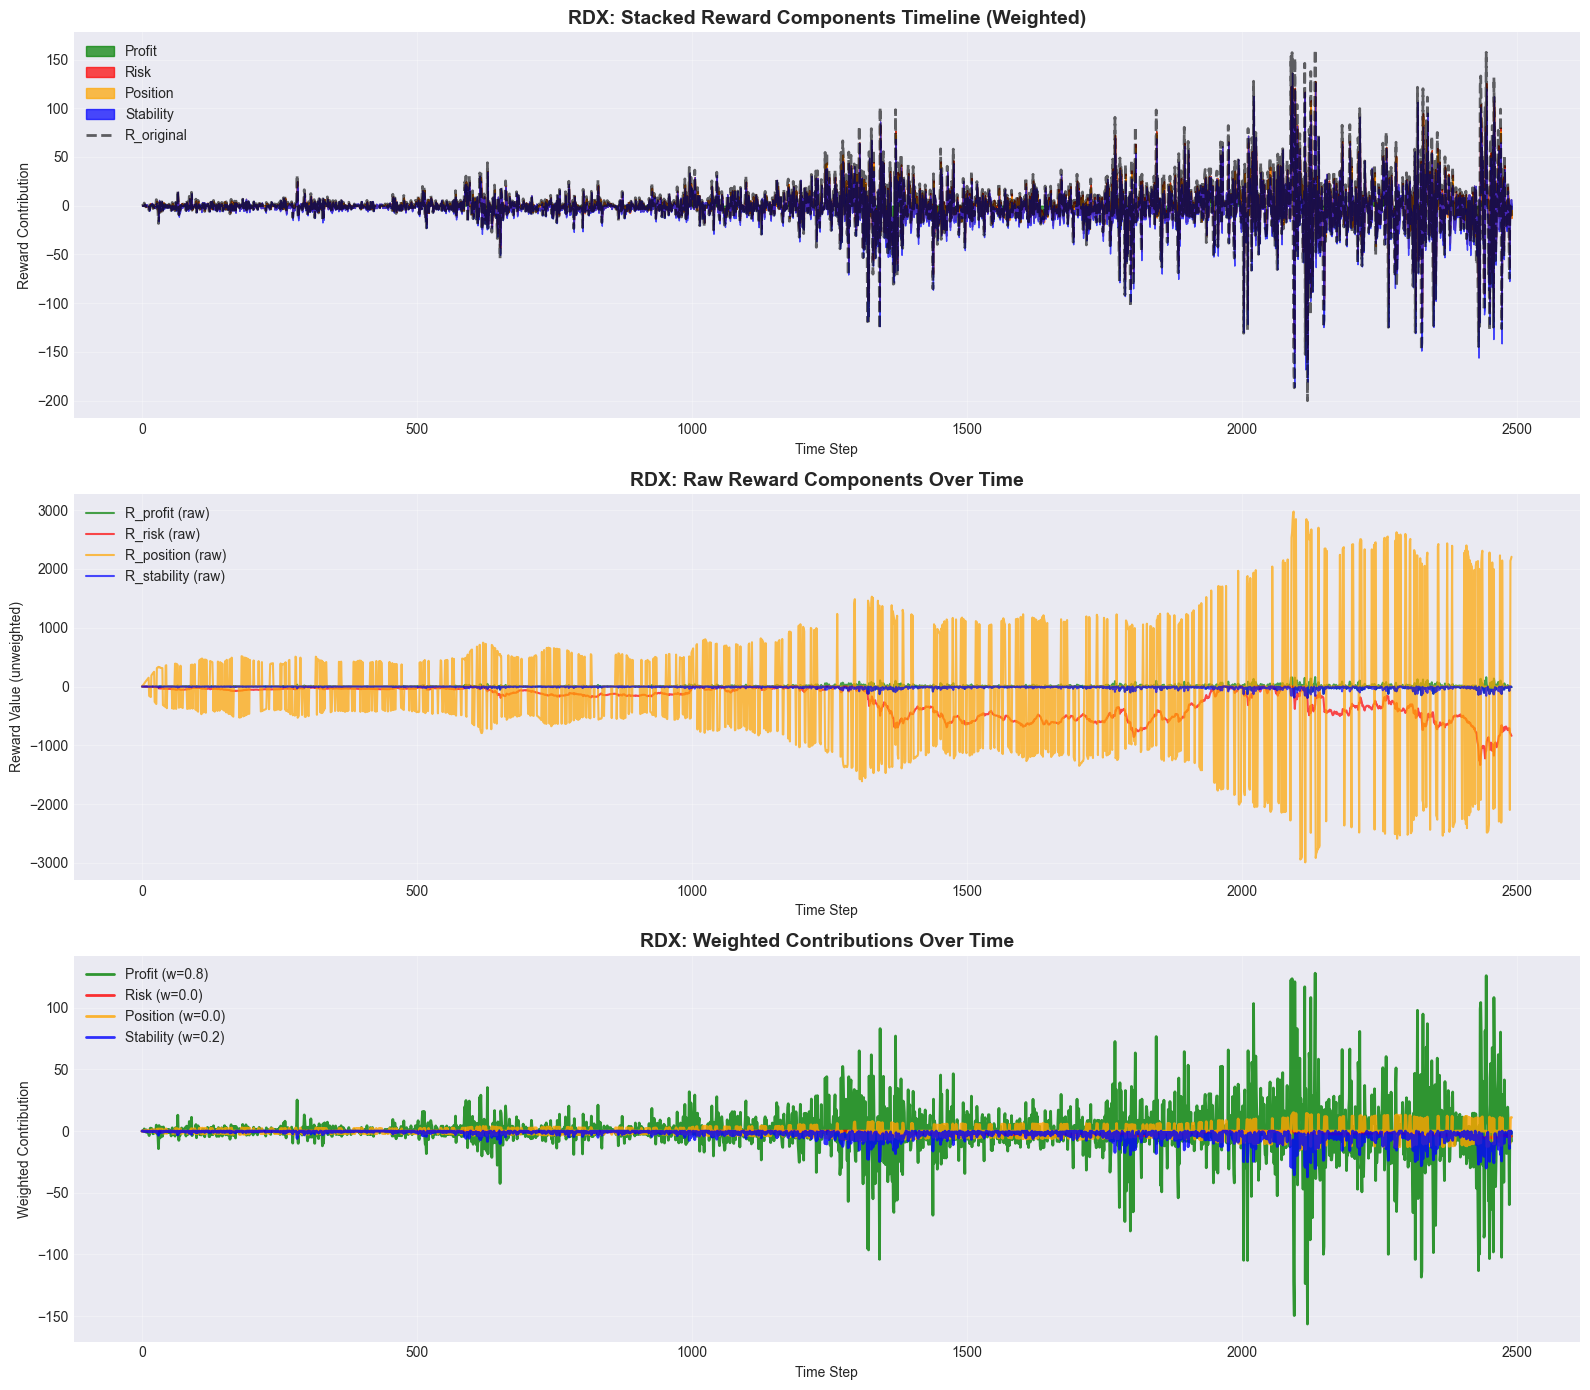

In [ ]:
# # Weighted contributions của từng component với RDX weights
# contrib_profit = w_rdx[0] * R_profit
# contrib_risk = w_rdx[1] * R_risk
# contrib_position = w_rdx[2] * R_position
# contrib_stability = w_rdx[3] * R_stability

# # Stacked Area Chart và Timeline
# fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# # Subplot 1: Stacked area chart
# x = np.arange(len(contrib_profit))
# axes[0].fill_between(x, 0, contrib_profit, label='Profit', alpha=0.7, color='green')
# axes[0].fill_between(x, contrib_profit, contrib_profit + contrib_risk, 
#                      label='Risk', alpha=0.7, color='red')
# axes[0].fill_between(x, contrib_profit + contrib_risk, 
#                      contrib_profit + contrib_risk + contrib_position,
#                      label='Position', alpha=0.7, color='orange')
# axes[0].fill_between(x, contrib_profit + contrib_risk + contrib_position,
#                      R_reconstructed, label='Stability', alpha=0.7, color='blue')
# axes[0].plot(R_original, 'k--', linewidth=2, alpha=0.6, label='R_original')
# axes[0].set_title('RDX: Stacked Reward Components Timeline (Weighted)', fontsize=14, fontweight='bold')
# axes[0].set_xlabel('Time Step')
# axes[0].set_ylabel('Reward Contribution')
# axes[0].legend(loc='best')
# axes[0].grid(True, alpha=0.3)

# # Subplot 2: Individual components over time
# axes[1].plot(R_profit, label='R_profit (raw)', alpha=0.7, linewidth=1.5, color='green')
# axes[1].plot(R_risk, label='R_risk (raw)', alpha=0.7, linewidth=1.5, color='red')
# axes[1].plot(R_position, label='R_position (raw)', alpha=0.7, linewidth=1.5, color='orange')
# axes[1].plot(R_stability, label='R_stability (raw)', alpha=0.7, linewidth=1.5, color='blue')
# axes[1].set_title('RDX: Raw Reward Components Over Time', fontsize=14, fontweight='bold')
# axes[1].set_xlabel('Time Step')
# axes[1].set_ylabel('Reward Value (unweighted)')
# axes[1].legend(loc='best')
# axes[1].grid(True, alpha=0.3)

# # Subplot 3: Weighted contributions
# axes[2].plot(contrib_profit, label=f'Profit (w={w_rdx[0]:.1f})', linewidth=2, alpha=0.8, color='green')
# axes[2].plot(contrib_risk, label=f'Risk (w={w_rdx[1]:.1f})', linewidth=2, alpha=0.8, color='red')
# axes[2].plot(contrib_position, label=f'Position (w={w_rdx[2]:.1f})', linewidth=2, alpha=0.8, color='orange')
# axes[2].plot(contrib_stability, label=f'Stability (w={w_rdx[3]:.1f})', linewidth=2, alpha=0.8, color='blue')
# axes[2].set_title('RDX: Weighted Contributions Over Time', fontsize=14, fontweight='bold')
# axes[2].set_xlabel('Time Step')
# axes[2].set_ylabel('Weighted Contribution')
# axes[2].legend(loc='best')
# axes[2].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # # Box plot - Phân phối
# # fig, ax = plt.subplots(figsize=(12, 7))
# # data_to_plot = [R_profit, R_risk, R_position, R_stability]
# # bp = ax.boxplot(data_to_plot, labels=['R_profit', 'R_risk', 'R_position', 'R_stability'],
# #                 patch_artist=True, showmeans=True)

# # colors = ['green', 'red', 'orange', 'blue']
# # for patch, color in zip(bp['boxes'], colors):
# #     patch.set_facecolor(color)
# #     patch.set_alpha(0.6)

# # ax.set_title('RDX: Box Plot - Phân phối 4 Reward Components', fontsize=16, fontweight='bold')
# # ax.set_ylabel('Reward Value')
# # ax.grid(True, axis='y', alpha=0.3)
# # plt.tight_layout()
# # plt.show()

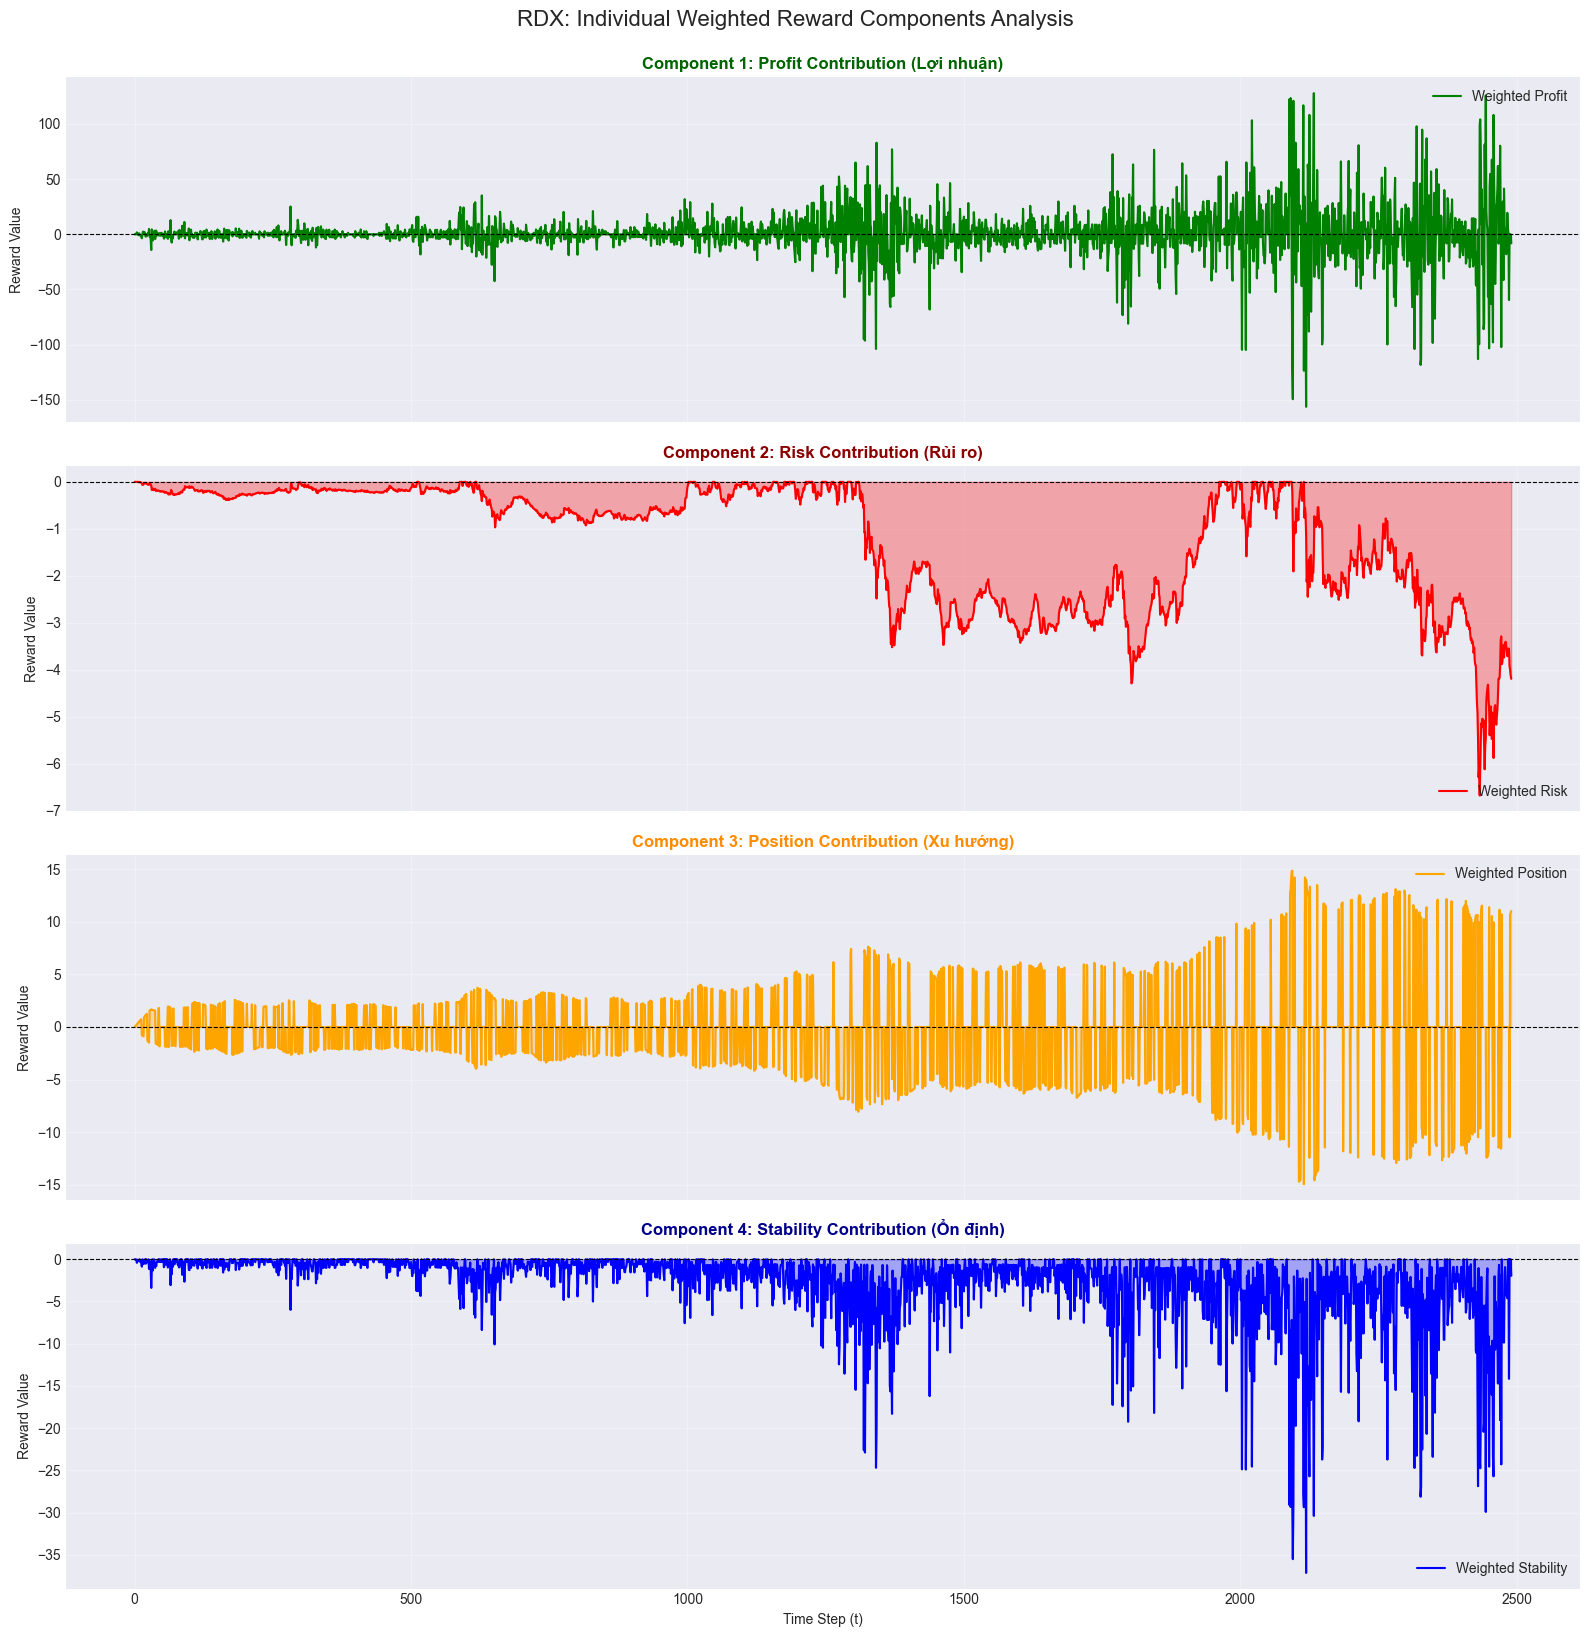

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Giả sử các biến contrib_* đã được tính toán như code của bạn:
# contrib_profit = w_rdx[0] * R_profit
# ...

# Thiết lập figure với 4 dòng (mỗi dòng 1 component)
fig, axes = plt.subplots(4, 1, figsize=(16, 16), sharex=True)
x = np.arange(len(contrib_profit))

# --- 1. PROFIT CONTRIBUTION ---
color_1 = 'green'
axes[0].plot(x, contrib_profit, color=color_1, label='Weighted Profit', linewidth=1.5)
axes[0].fill_between(x, 0, contrib_profit, color=color_1, alpha=0.3)
axes[0].set_title('Component 1: Profit Contribution (Lợi nhuận)', fontsize=12, fontweight='bold', color='darkgreen')
axes[0].set_ylabel('Reward Value')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='black', linewidth=0.8, linestyle='--')

# --- 2. RISK CONTRIBUTION ---
color_2 = 'red'
axes[1].plot(x, contrib_risk, color=color_2, label='Weighted Risk', linewidth=1.5)
axes[1].fill_between(x, 0, contrib_risk, color=color_2, alpha=0.3)
axes[1].set_title('Component 2: Risk Contribution (Rủi ro)', fontsize=12, fontweight='bold', color='darkred')
axes[1].set_ylabel('Reward Value')
axes[1].legend(loc='lower right') # Risk thường âm nên để legend ở dưới cho dễ nhìn
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0, color='black', linewidth=0.8, linestyle='--')

# --- 3. POSITION CONTRIBUTION ---
color_3 = 'orange'
axes[2].plot(x, contrib_position, color=color_3, label='Weighted Position', linewidth=1.5)
axes[2].fill_between(x, 0, contrib_position, color=color_3, alpha=0.3)
axes[2].set_title('Component 3: Position Contribution (Xu hướng)', fontsize=12, fontweight='bold', color='darkorange')
axes[2].set_ylabel('Reward Value')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(0, color='black', linewidth=0.8, linestyle='--')

# --- 4. STABILITY CONTRIBUTION ---
color_4 = 'blue'
axes[3].plot(x, contrib_stability, color=color_4, label='Weighted Stability', linewidth=1.5)
axes[3].fill_between(x, 0, contrib_stability, color=color_4, alpha=0.3)
axes[3].set_title('Component 4: Stability Contribution (Ổn định)', fontsize=12, fontweight='bold', color='darkblue')
axes[3].set_ylabel('Reward Value')
axes[3].set_xlabel('Time Step (t)')
axes[3].legend(loc='lower right')
axes[3].grid(True, alpha=0.3)
axes[3].axhline(0, color='black', linewidth=0.8, linestyle='--')

# Tinh chỉnh layout
plt.tight_layout()
plt.suptitle('RDX: Individual Weighted Reward Components Analysis', y=1.02, fontsize=16)
plt.show()

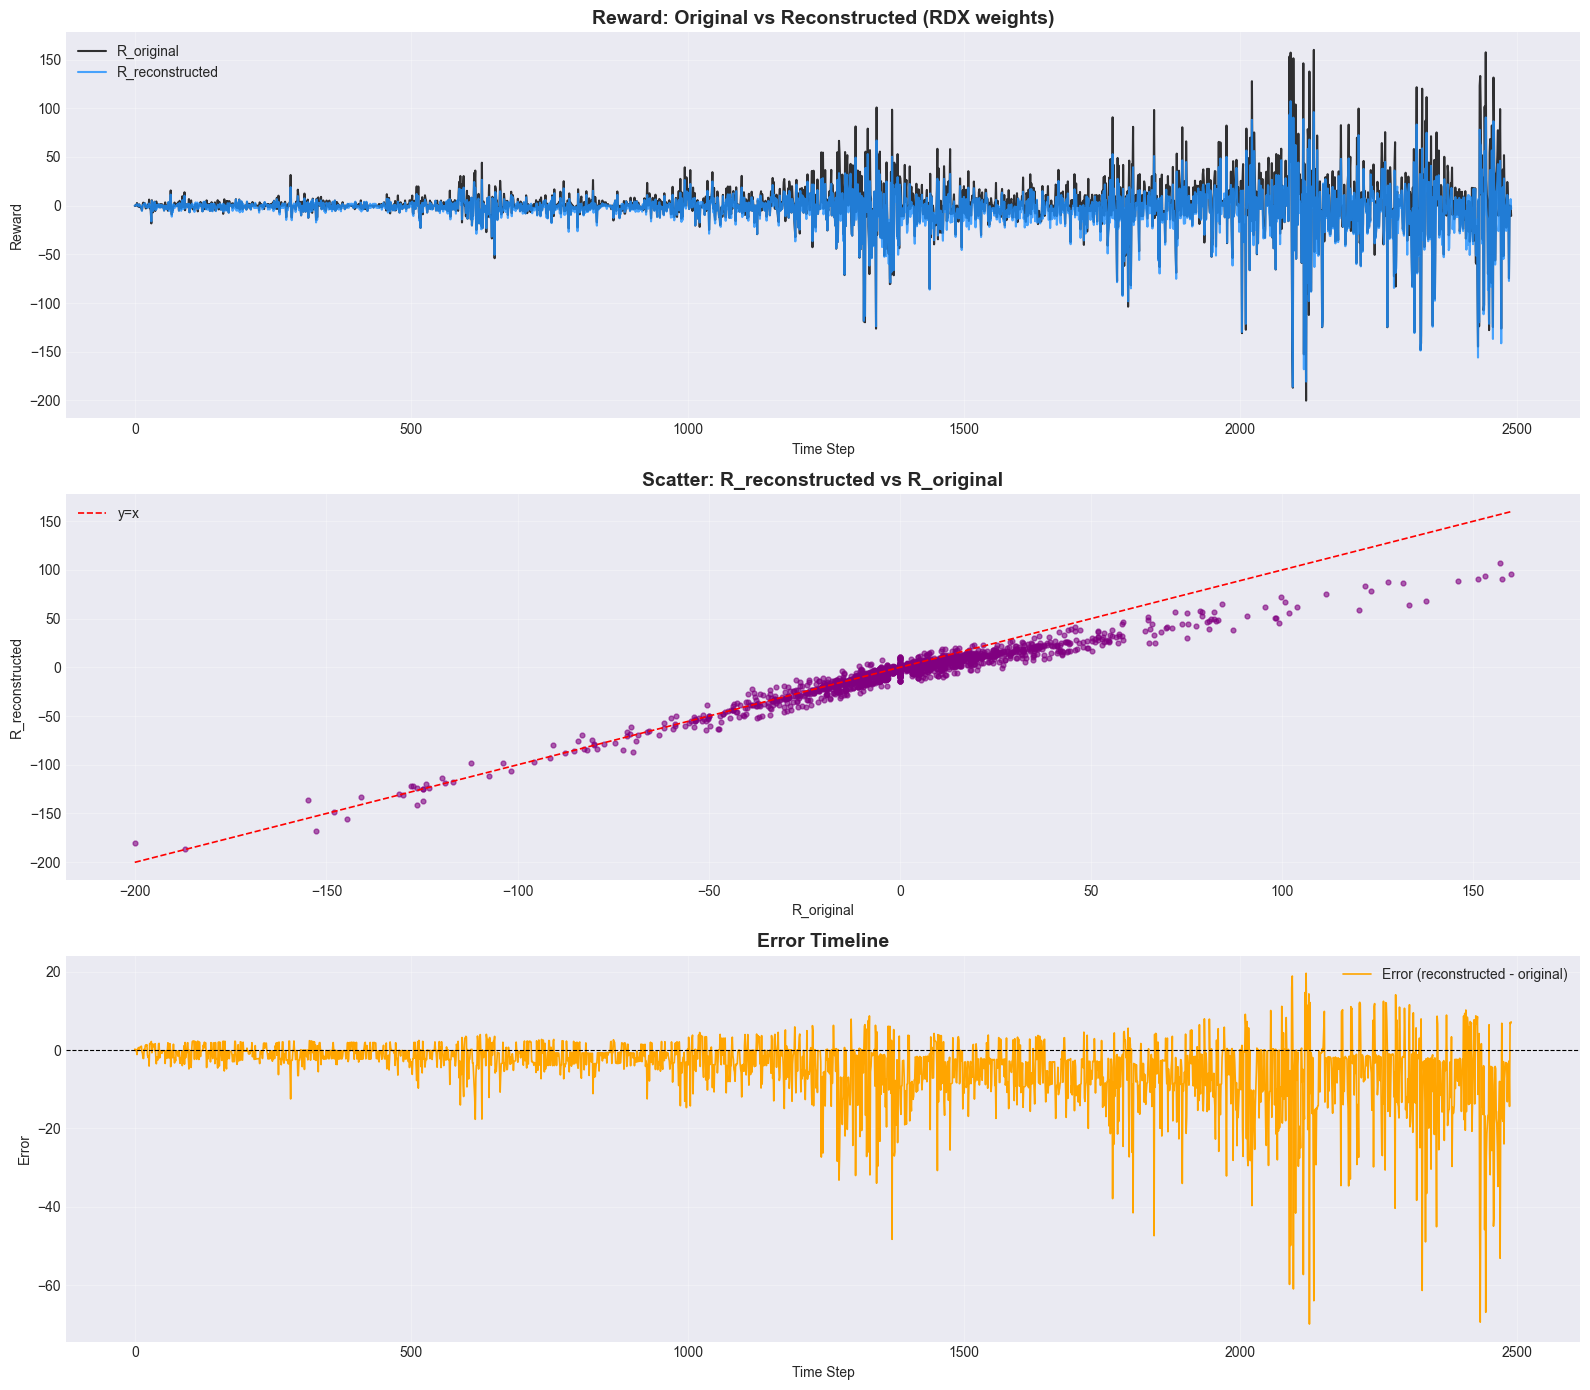

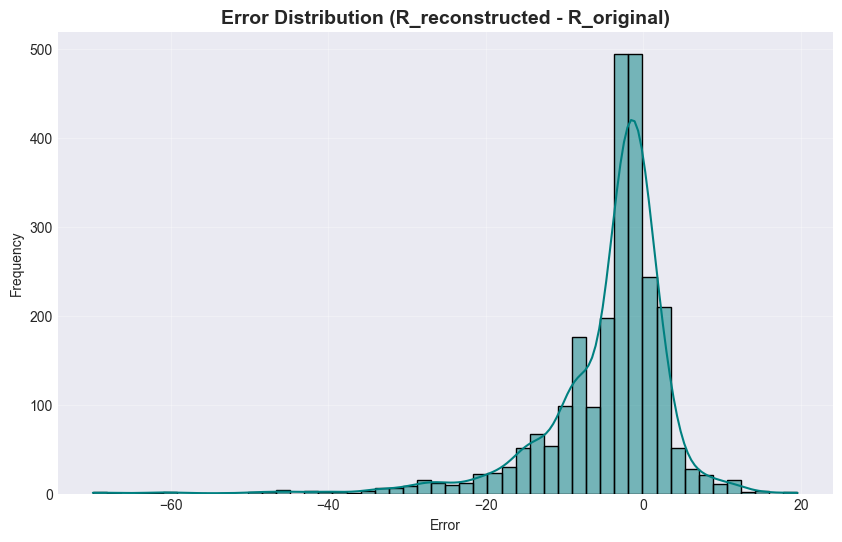

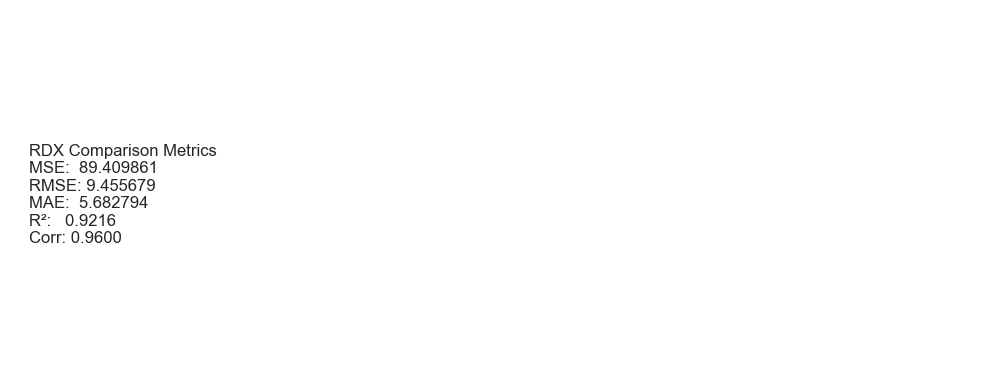

In [14]:
# So sánh trực quan R_reconstructed (từ weights) với R_original (reward gốc)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Giả định các biến đã có: R_original, R_reconstructed, w_rdx, R_profit, R_risk, R_position, R_stability

# 1) Line plot: Original vs Reconstructed theo thời gian
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

x = np.arange(len(R_reconstructed))
axes[0].plot(x, R_original, label='R_original', color='black', linewidth=1.5, alpha=0.8)
axes[0].plot(x, R_reconstructed, label='R_reconstructed', color='dodgerblue', linewidth=1.5, alpha=0.8)
axes[0].set_title('Reward: Original vs Reconstructed (RDX weights)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Reward')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# 2) Scatter: Original vs Reconstructed + đường y=x
axes[1].scatter(R_original, R_reconstructed, s=12, alpha=0.6, color='purple')
min_val = min(R_original.min(), R_reconstructed.min())
max_val = max(R_original.max(), R_reconstructed.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1.2, label='y=x')
axes[1].set_title('Scatter: R_reconstructed vs R_original', fontsize=14, fontweight='bold')
axes[1].set_xlabel('R_original')
axes[1].set_ylabel('R_reconstructed')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

# 3) Sai số: e = R_reconstructed - R_original (timeline + histogram)
error = R_reconstructed - R_original
axes[2].plot(x, error, color='orange', linewidth=1.2, label='Error (reconstructed - original)')
axes[2].axhline(0, color='black', linestyle='--', linewidth=0.8)
axes[2].set_title('Error Timeline', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Time Step')
axes[2].set_ylabel('Error')
axes[2].legend(loc='best')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4) Histogram sai số + KDE
plt.figure(figsize=(10,6))
sns.histplot(error, bins=50, kde=True, color='teal')
plt.title('Error Distribution (R_reconstructed - R_original)', fontsize=14, fontweight='bold')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# 5) Bảng metrics hiển thị trực quan trên hình
mse = ((error)**2).mean()
rmse = np.sqrt(mse)
mae = np.abs(error).mean()
r2 = np.corrcoef(R_original, R_reconstructed)[0,1]**2
corr = np.corrcoef(R_original, R_reconstructed)[0,1]

fig, ax = plt.subplots(figsize=(10,4))
ax.axis('off')
text = (
    f"RDX Comparison Metrics\n"
    f"MSE:  {mse:.6f}\n"
    f"RMSE: {rmse:.6f}\n"
    f"MAE:  {mae:.6f}\n"
    f"R²:   {r2:.4f}\n"
    f"Corr: {corr:.4f}"
)
ax.text(0.02, 0.5, text, fontsize=12, va='center', ha='left')
plt.tight_layout()
plt.show()

# # 6) Optional: Stacked contributions vs Original (đã vẽ trước, nhưng gom lại ở đây nếu cần)
# # Đây là biểu đồ thể hiện tổng đóng góp từng component (weighted) so với reward gốc
# contrib_profit = w_rdx[0] * R_profit
# contrib_risk = w_rdx[1] * R_risk
# contrib_position = w_rdx[2] * R_position
# contrib_stability = w_rdx[3] * R_stability

# fig, ax = plt.subplots(figsize=(16, 6))
# ax.plot(R_original, 'k--', linewidth=1.5, alpha=0.7, label='R_original')
# ax.plot(R_reconstructed, color='blue', linewidth=1.8, alpha=0.8, label='R_reconstructed')
# ax.plot(contrib_profit, color='green', alpha=0.6, label='Profit (weighted)')
# ax.plot(contrib_risk, color='red', alpha=0.6, label='Risk (weighted)')
# ax.plot(contrib_position, color='orange', alpha=0.6, label='Position (weighted)')
# ax.plot(contrib_stability, color='blue', alpha=0.4, linestyle=':', label='Stability (weighted)')
# ax.set_title('Original vs Reconstructed and Component Contributions', fontsize=14, fontweight='bold')
# ax.set_xlabel('Time Step')
# ax.set_ylabel('Reward / Contribution')
# ax.legend(loc='best')
# ax.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()